In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0, std 1
])

# Load datasets
training_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 32
train_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding='same')  
        self.pool = nn.MaxPool2d(2, 2)                                    
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding='same') 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.flatten = nn.Flatten()                                     
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))        # Output: 32 x 28 x 28
        x = self.pool(x)                    # Output: 32 x 14 x 14
        x = self.relu(self.conv2(x))        # Output: 64 x 14 x 14
        x = self.pool(x)                    # Output: 64 x 7 x 7
        x = self.flatten(x)                 # Output: 64 * 7 * 7 = 3136
        x = self.relu(self.fc1(x))          # Fully connected layer
        x = self.dropout(x)
        x = self.fc2(x)                     # notera att vi faktiskt EJ behöver explicit ange softmax aktivering här på output layer
                                            # anledningen är att vi i nästa skede använder CrossEntropyLoss, och den har faktiskt
                                            # softmax-aktivering inbakad i sig. Med andra ord sköter CrossEntropyLoss den sista aktiveringen åt oss.
                                                                                  
        return x

In [5]:
model = CNN()
model = model.to(device)  # Move to device
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [6]:
EPOCHS = 20
LEARNING_RATE = 0.005


model = CNN()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

# ----------------------------------------------------------------------------

batch_train_losses = []
epoch_train_losses = []
epoch_test_losses = []
epoch_test_accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    model.train()  # Set model to training mode

    
    for batch in train_dataloader:
        input_features, y_true = batch
        input_features, y_true = input_features.to(device), y_true.to(device)
        
        y_pred = model(input_features)  
        loss = loss_function(y_pred, y_true)  
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  
        
        batch_loss = loss.item()
        batch_train_losses.append(batch_loss)
    
    
    epoch_average_loss = np.average(batch_train_losses[-len(train_dataloader):])
    epoch_train_losses.append(epoch_average_loss)
    print(f"Training loss: {epoch_average_loss}")
    
    # ----------------------------------------
    # Evaluation section
    # ----------------------------------------
    
    model.eval()  # Set model to evaluation mode

    with torch.no_grad(): 
      
        x_test, y_test = next(iter(test_dataloader))
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        y_pred = model(x_test)
        test_loss = loss_function(y_pred, y_test).item()
        epoch_test_losses.append(test_loss)
        print(f"Test loss: {test_loss}")
        
        # Evaluation accuracy
        _, predicted_class = torch.max(y_pred, dim=1)
        accuracy = (predicted_class == y_test).float().mean().item()
        epoch_test_accuracies.append(accuracy)
        print(f"Test accuracy: {accuracy}")

Epoch 1/20
Training loss: 0.9337174066543579
Test loss: 0.7677788734436035
Test accuracy: 0.71875
Epoch 2/20
Training loss: 0.5719774830420812
Test loss: 0.7927051782608032
Test accuracy: 0.75
Epoch 3/20
Training loss: 0.49461874205271406
Test loss: 0.6798587441444397
Test accuracy: 0.75
Epoch 4/20
Training loss: 0.44318011995951334
Test loss: 0.5569043755531311
Test accuracy: 0.78125
Epoch 5/20
Training loss: 0.4085064843217532
Test loss: 0.545298159122467
Test accuracy: 0.8125
Epoch 6/20
Training loss: 0.3845213523864746
Test loss: 0.4607386291027069
Test accuracy: 0.84375
Epoch 7/20
Training loss: 0.3673090447266897
Test loss: 0.4498854875564575
Test accuracy: 0.84375
Epoch 8/20
Training loss: 0.3529123632828395
Test loss: 0.473505437374115
Test accuracy: 0.875
Epoch 9/20
Training loss: 0.33847331179181733
Test loss: 0.3529701232910156
Test accuracy: 0.875
Epoch 10/20
Training loss: 0.33014846243858337
Test loss: 0.4401393532752991
Test accuracy: 0.84375
Epoch 11/20
Training loss: 0

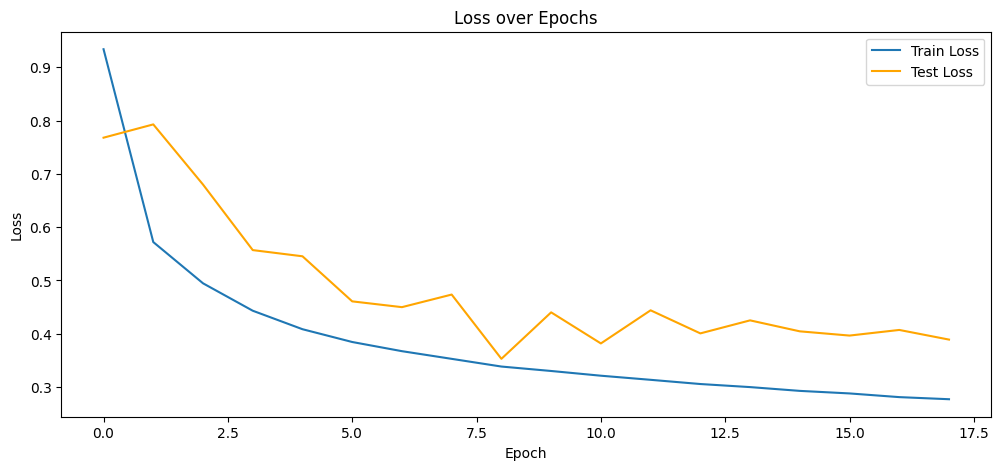

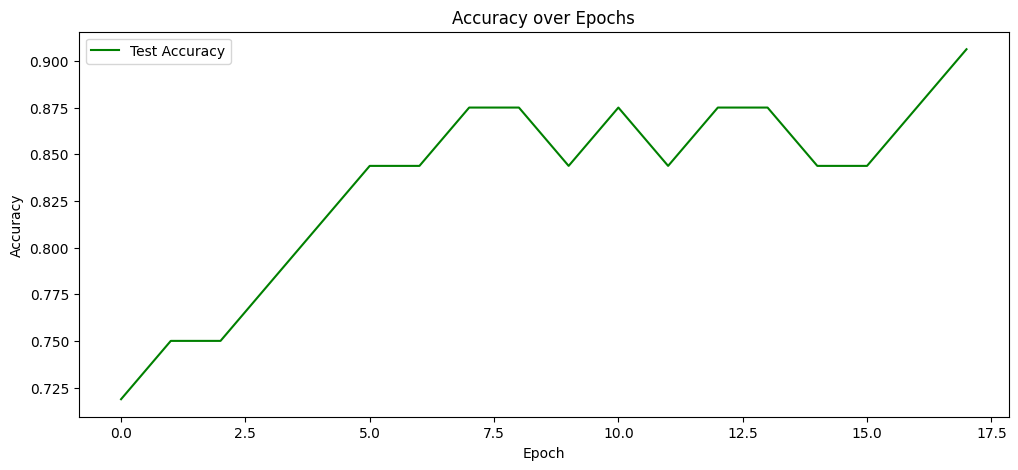

In [7]:
# Plot loss curves
plt.figure(figsize=(12, 5))
plt.plot(epoch_train_losses[:-2], label='Train Loss')
plt.plot(epoch_test_losses[:-2], label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Plot test accuracies
plt.figure(figsize=(12, 5))
plt.plot(epoch_test_accuracies[:-2], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

---

## Uppgifter

**1)**

Kolla CNN-modellen vi definierade. Förstår du input och output size i varje lager?


**2)**

Träna nätverket med loopen ovan.

Det är ett relativt litet nätverk, särskilt fully conntected delen, om man jämför med vad vi använde när vi tränade på detta dataset förra lektionen.
Är det lätt att få bättre prestanda nu jämfört med när vi använde exklusivt fully connected layers, trots att vi har en relativt litet CNN?

**3)**

Hur många parametrar har nätverket totalt? Hur många per lager?

**4)**

Experimentera själv med att ändra i arkitekturen och träna om! Kan du nå bättre resultat på test-settet?

Tips: Kan också vara en bra idé att implementera confusion matrix här för att evaluera prestanda per klass också, snarare än bara se till total accuracy.

